In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib torch torchvision

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3r9tiv5x
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3r9tiv5x
  error: 4335 bytes of body are still expected
  fetch-pack: unexpected disconnect while reading sideband packet
  fatal: early EOF
  fatal: index-pack failed
  Auto packing the repository in background for optimum performance.
  See "git help gc" for manual housekeeping.
  Auto packing the repository in background for optimum performance.
  See "git help gc" for manual housekeeping.
  Auto packing the repository in background for optimum performance.
  See "git help gc" for manual housekeeping.
  Auto packing the repository in background for optimum performance.
  See "git help gc" for manual housekeeping.
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor

In [8]:
import os

# 1. 모델 체크포인트 및 경로 설정
CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"  # 사전 훈련된 SAM 모델 경로 (다운로드 필요)

if not os.path.exists(CHECKPOINT_PATH):
    print("Downloading SAM model checkpoint...")
    !wget $CHECKPOINT_URL -O $CHECKPOINT_PATH
    print("Download complete!")
else:
    print("Checkpoint already exists!")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # GPU/CPU 선택
MODEL_TYPE = "vit_h"

--2024-12-11 01:26:28--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.70, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  27.0MB/s    in 21s     

2024-12-11 01:26:49 (116 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

Download complete!


In [9]:
# 2. SAM 모델 로드
print("Loading SAM model...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(DEVICE)
predictor = SamPredictor(sam)
print("SAM model loaded successfully.")

Loading SAM model...


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


SAM model loaded successfully.


Saving cat.jpg to cat.jpg
업로드된 파일 이름: cat.jpg


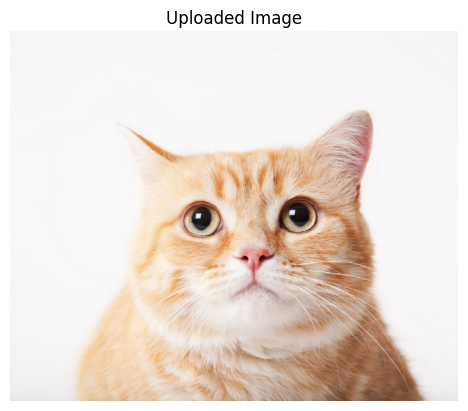

In [10]:
# 3. 이미지 불러오기 및 전처리

from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()  # 업로드 창이 나타나면 파일 선택

def load_uploaded_image(uploaded_files):
    for filename in uploaded_files.keys():  # 업로드된 파일 이름 가져오기
        print(f"업로드된 파일 이름: {filename}")

        # OpenCV로 이미지 읽기
        image_bgr = cv2.imread(filename)  # 파일 이름으로 이미지 읽기 (BGR 형식)

        if image_bgr is None:
            print("이미지를 불러오지 못했습니다. 파일 형식을 확인해주세요.")
            return None

        # BGR -> RGB 변환
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        return image_rgb

image_rgb = load_uploaded_image(uploaded)

if image_rgb is not None:
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()
else:
    print("이미지 로딩 실패.")

In [11]:
# 4. SAM Predictor에 이미지 입력
print("Setting image to the predictor...")
predictor.set_image(image_rgb)

Setting image to the predictor...


In [12]:
# 5. 프롬프트 입력 (점과 박스)
# 예제 프롬프트 입력 설정
input_point = np.array([[300, 500]])  # 분할할 객체 주변의 점 (x, y)
input_label = np.array([1])  # 포인트 레이블 (1: 객체, 0: 배경)
input_box = np.array([200, 400, 600, 800])  # 분할할 객체 주변의 박스 (x_min, y_min, x_max, y_max)

In [13]:
# 6. SAM 모델로 마스크 예측
print("Running SAM prediction with point prompts...")
masks_point, scores_point, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,  # 다중 마스크 출력
)

print("Running SAM prediction with box prompts...")
masks_box, scores_box, _ = predictor.predict(
    box=input_box,
    multimask_output=True,  # 다중 마스크 출력
)

Running SAM prediction with point prompts...
Running SAM prediction with box prompts...


In [14]:
# 7. 결과 시각화 함수
def visualize_results(image, masks, scores, prompt_type="Point"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f"Segment Anything Result ({prompt_type} Prompt)")
    for mask, score in zip(masks, scores):
        plt.imshow(mask, alpha=0.5, cmap="jet")
        plt.title(f"Score: {score:.3f}")
    plt.axis('off')
    plt.show()

Visualizing point prompt results...


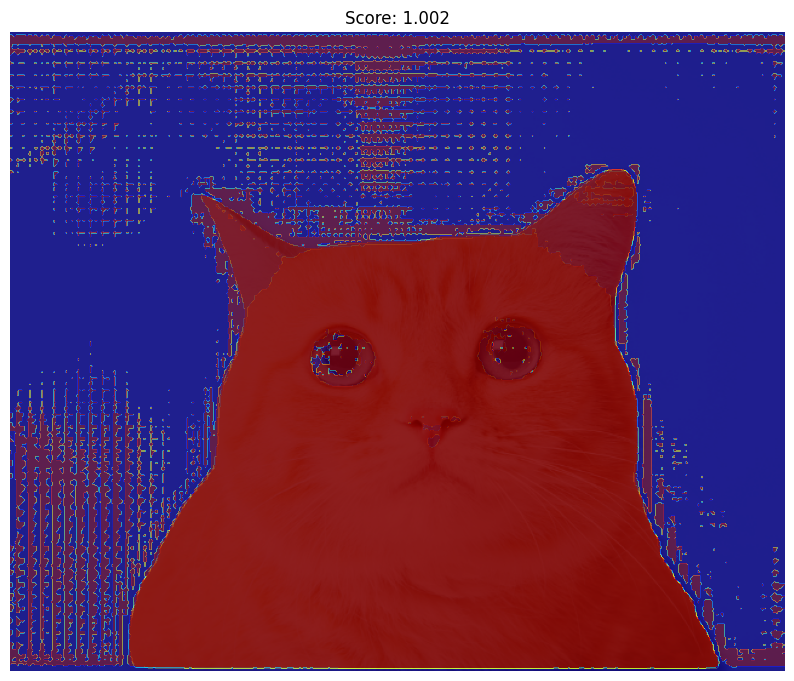

In [15]:
# 점 프롬프트 결과 시각화
print("Visualizing point prompt results...")
visualize_results(image_rgb, masks_point, scores_point, prompt_type="Point")

Visualizing box prompt results...


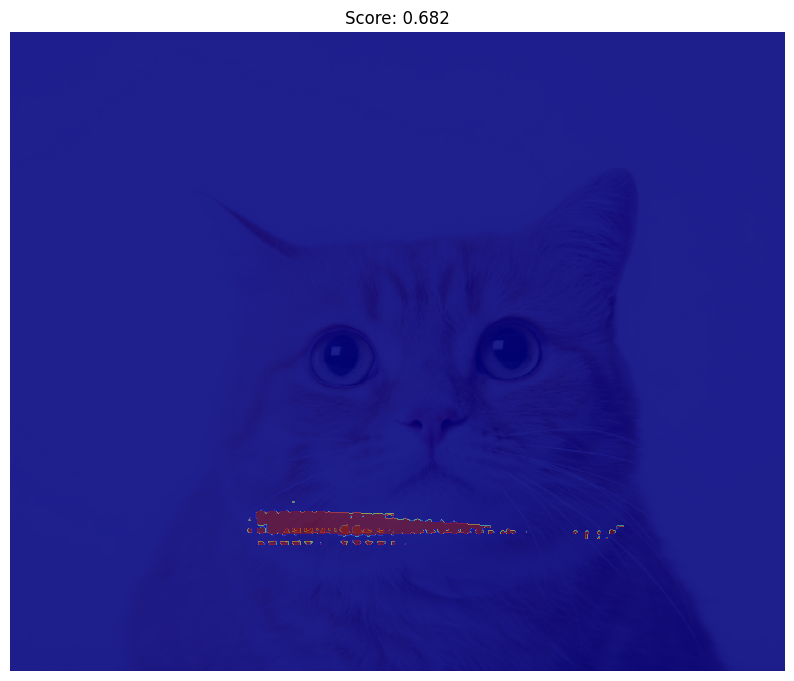

In [16]:
# 박스 프롬프트 결과 시각화
print("Visualizing box prompt results...")
visualize_results(image_rgb, masks_box, scores_box, prompt_type="Box")

In [17]:
# 8. 다중 마스크 출력
print("Multi-mask results with scores:")
for i, (mask, score) in enumerate(zip(masks_box, scores_box)):
    print(f"Mask {i+1}: Score {score:.3f}")

Multi-mask results with scores:
Mask 1: Score 0.325
Mask 2: Score 0.607
Mask 3: Score 0.682
